### RNN

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [6]:
import pandas as pd

# Load dataset without date parsing
df = pd.read_csv(r"C:\Users\USER\OneDrive\Desktop\Code\DL_tutorial\individual+household+electric+power+consumption\household_power_consumption.txt", 
                 sep=";", na_values=["?", "nan"])

# Combine 'Date' and 'Time' columns into a single datetime column
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)

# Drop the original Date and Time columns
df.drop(columns=["Date", "Time"], inplace=True)

# Set datetime as the index
df.set_index("datetime", inplace=True)

# Convert Global_active_power to numeric
df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")

# Drop NaNs
df.dropna(inplace=True)

print(df.head())


                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

In [8]:
scaler = MinMaxScaler()
df["Global_active_power"] = scaler.fit_transform(df[["Global_active_power"]])

In [10]:
# Function to create input-output sequences
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 30  # Number of past timesteps to use as input

data_values = df["Global_active_power"].values
X, y = create_sequences(data_values, TIME_STEPS)

In [12]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 1639400, Test size: 409850


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define RNN model
model = Sequential([
    SimpleRNN(50, activation="relu", input_shape=(TIME_STEPS, 1)),
    Dense(1)  # Output layer
])

model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


D:\jupyter\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 195s 4ms/step - loss: 7.3171e-04 - val_loss: 3.9133e-04
Epoch 2/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 199s 4ms/step - loss: 5.8388e-04 - val_loss: 3.7910e-04
Epoch 3/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 208s 4ms/step - loss: 5.6843e-04 - val_loss: 3.7930e-04
Epoch 4/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 211s 4ms/step - loss: 5.6399e-04 - val_loss: 3.8151e-04
Epoch 5/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 214s 4ms/step - loss: 5.5894e-04 - val_loss: 3.6829e-04
Epoch 6/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 221s 4ms/step - loss: 5.7211e-04 - val_loss: 3.8878e-04
Epoch 7/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 226s 4ms/step - loss: 5.6709e-04 - val_loss: 3.8069e-04
Epoch 8/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 228s 4ms/step - loss: 5.5894e-04 - val_loss: 3.7180e-04
Epoch 9/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 225s 4ms/step - loss: 5.6025e-04 - val_loss: 3.7122e-04
Epoch 10/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 230s 4ms/step - loss: 5.5631e-04 - val_loss: 3.6267e-04

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
MAE: 0.0921, MSE: 0.0452, RMSE: 0.2126


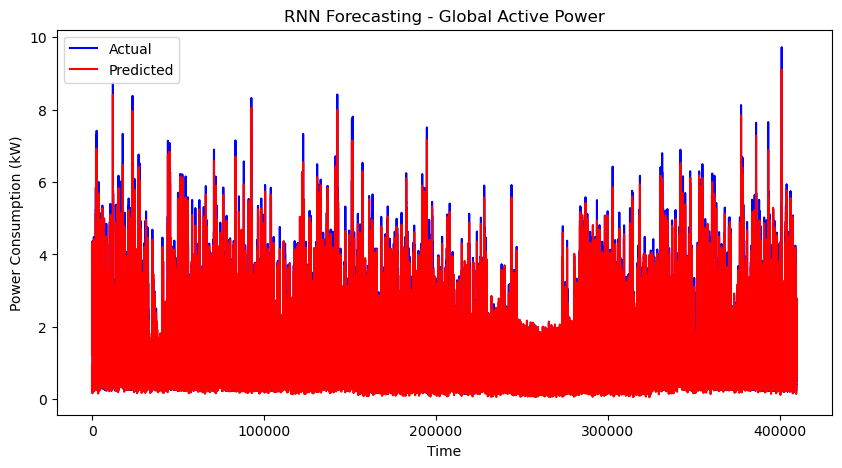

In [15]:
# Predict
y_pred = model.predict(X_test)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Compute metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Actual", color="blue")
plt.plot(y_pred_inv, label="Predicted", color="red")
plt.title("RNN Forecasting - Global Active Power")
plt.xlabel("Time")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.show()

### LSTM

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
# Load dataset
df = pd.read_csv(r"C:\Users\USER\OneDrive\Desktop\Code\DL_tutorial\individual+household+electric+power+consumption\household_power_consumption.txt", 
                 sep=";", na_values=["?", "nan"])

# Combine 'Date' and 'Time' into a single datetime column
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)

# Drop original Date and Time columns
df.drop(columns=["Date", "Time"], inplace=True)

# Set datetime as index
df.set_index("datetime", inplace=True)

# Convert 'Global_active_power' to numeric
df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")

# Drop NaN values
df.dropna(inplace=True)

In [23]:
# Normalize data
scaler = MinMaxScaler()
df["Global_active_power"] = scaler.fit_transform(df[["Global_active_power"]])


In [25]:
# Function to create time-series sequences
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Define time step (sequence length)
TIME_STEPS = 30

In [27]:
# Prepare sequences
data_values = df["Global_active_power"].values
X, y = create_sequences(data_values, TIME_STEPS)

# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for LSTM (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=False, input_shape=(TIME_STEPS, 1)),
    Dense(1)  # Output layer
])

model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


D:\jupyter\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 25691s 501ms/step - loss: 7.1709e-04 - val_loss: 3.7849e-04
Epoch 2/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 927s 18ms/step - loss: 5.6850e-04 - val_loss: 3.7467e-04
Epoch 3/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 966s 19ms/step - loss: 5.3841e-04 - val_loss: 3.5284e-04
Epoch 4/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 921s 18ms/step - loss: 5.2981e-04 - val_loss: 3.5359e-04
Epoch 5/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 923s 18ms/step - loss: 5.2681e-04 - val_loss: 3.4946e-04
Epoch 6/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 947s 18ms/step - loss: 5.1392e-04 - val_loss: 3.4698e-04
Epoch 7/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 935s 18ms/step - loss: 5.0741e-04 - val_loss: 3.4103e-04
Epoch 8/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 718s 14ms/step - loss: 5.0514e-04 - val_loss: 3.7983e-04
Epoch 9/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 554s 11ms/step - loss: 5.0728e-04 - val_loss: 3.4780e-04
Epoch 10/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 478s 9ms/step - loss: 5.0313e-04 - val_loss

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step
MAE: 0.0767, MSE: 0.0418, RMSE: 0.2044


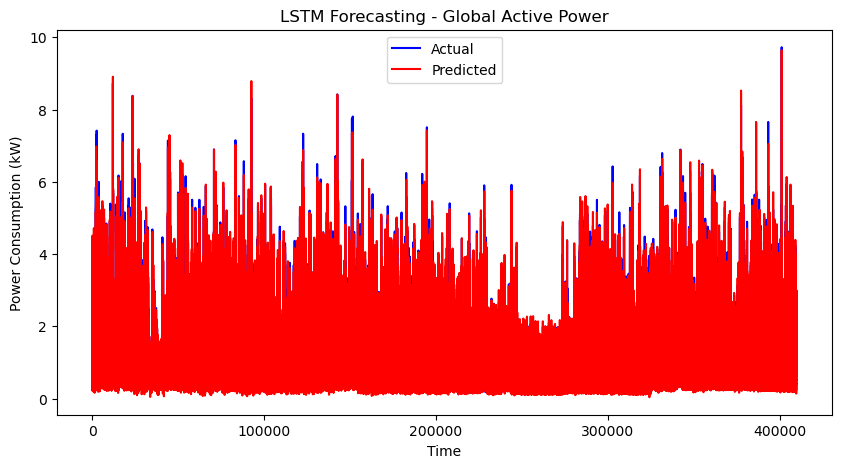

In [28]:
# Predict
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Performance metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Actual", color="blue")
plt.plot(y_pred_inv, label="Predicted", color="red")
plt.title("LSTM Forecasting - Global Active Power")
plt.xlabel("Time")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.show()

### GRU

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [34]:
# Load dataset
df = pd.read_csv(r"C:\Users\USER\OneDrive\Desktop\Code\DL_tutorial\individual+household+electric+power+consumption\household_power_consumption.txt", 
                 sep=";", na_values=["?", "nan"])

# Combine 'Date' and 'Time' into a single datetime column
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)

# Drop original Date and Time columns
df.drop(columns=["Date", "Time"], inplace=True)

# Set datetime as index
df.set_index("datetime", inplace=True)

# Convert 'Global_active_power' to numeric
df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")

# Drop NaN values
df.dropna(inplace=True)


In [36]:
# Normalize data
scaler = MinMaxScaler()
df["Global_active_power"] = scaler.fit_transform(df[["Global_active_power"]])


In [38]:
# Function to create time-series sequences
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [40]:
# Define time step (sequence length)
TIME_STEPS = 30

# Prepare sequences
data_values = df["Global_active_power"].values
X, y = create_sequences(data_values, TIME_STEPS)

In [42]:
# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for GRU (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [44]:
# Build GRU model
model = Sequential([
    GRU(50, activation="relu", return_sequences=False, input_shape=(TIME_STEPS, 1)),
    Dense(1)  # Output layer
])

model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


D:\jupyter\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 1014s 20ms/step - loss: 6.6648e-04 - val_loss: 3.9834e-04
Epoch 2/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 1029s 20ms/step - loss: 5.8381e-04 - val_loss: 3.7267e-04
Epoch 3/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 1125s 22ms/step - loss: 5.6848e-04 - val_loss: 3.6945e-04
Epoch 4/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 1939s 38ms/step - loss: 5.6175e-04 - val_loss: 3.6532e-04
Epoch 5/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 537s 10ms/step - loss: 5.5527e-04 - val_loss: 3.6974e-04
Epoch 6/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 557s 11ms/step - loss: 5.4600e-04 - val_loss: 3.5963e-04
Epoch 7/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 558s 11ms/step - loss: 5.4347e-04 - val_loss: 3.5781e-04
Epoch 8/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 557s 11ms/step - loss: 5.3826e-04 - val_loss: 3.6883e-04
Epoch 9/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 582s 11ms/step - loss: 5.3477e-04 - val_loss: 3.6554e-04
Epoch 10/20
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 581s 11ms/step - loss: 5.3145e-04 - val_lo

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step
MAE: 0.0811, MSE: 0.0424, RMSE: 0.2060


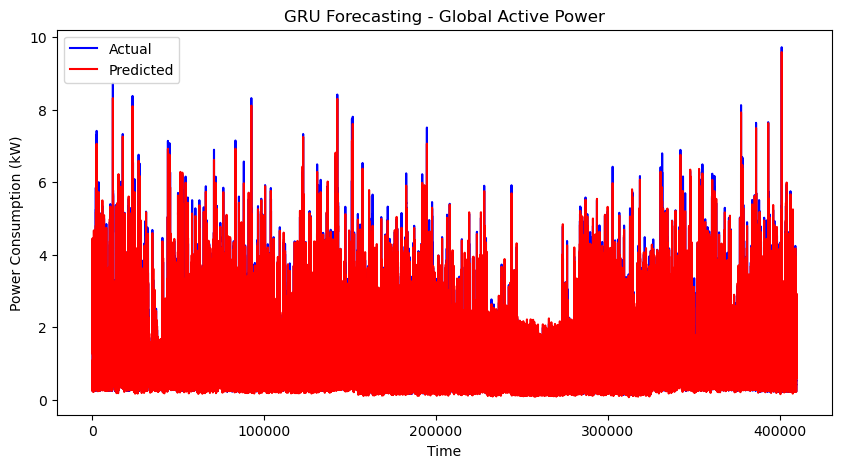

In [45]:
# Predict
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Performance metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Actual", color="blue")
plt.plot(y_pred_inv, label="Predicted", color="red")
plt.title("GRU Forecasting - Global Active Power")
plt.xlabel("Time")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.show()

### Modified RNN

In [80]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [94]:
# Load dataset
df = pd.read_csv(r"C:\Users\USER\OneDrive\Desktop\Code\DL_tutorial\individual+household+electric+power+consumption\household_power_consumption.txt", 
                 sep=";", na_values=["?", "nan"])

df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df.drop(columns=["Date", "Time"], inplace=True)
df.set_index("datetime", inplace=True)

df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")
df.dropna(inplace=True)

# Reduce dataset size further (every 10th row)
df = df.iloc[::5, :]


In [100]:
scaler = MinMaxScaler()
df["Global_active_power"] = scaler.fit_transform(df[["Global_active_power"]])

In [104]:
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)


In [106]:
TIME_STEPS = 10
data_values = df["Global_active_power"].values
X, y = create_sequences(data_values, TIME_STEPS)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [108]:
#  Optimized RNN Model 
model = Sequential([
    SimpleRNN(16, activation="relu", return_sequences=True, input_shape=(TIME_STEPS, 1)),
    Dropout(0.1),
    SimpleRNN(8, activation="relu", return_sequences=False),
    Dense(4, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

#  Optimized Callbacks
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/20


D:\jupyter\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2562/2562 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0027 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 2/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0024 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 3/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0023 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0023 - val_loss: 0.0017 - learning_rate: 5.0000e-04
Epoch 5/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0023 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 6/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 2.5000e-04
Epoch 7/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0023 - val_loss: 0.0016 - learning_rate: 2.5000e-04
Epoch 8/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 1.2500e-04
Epoch 9/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0022 - val_loss: 0.0016 

2562/2562 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
MAE: 0.0223, MSE: 0.0016, RMSE: 0.0404


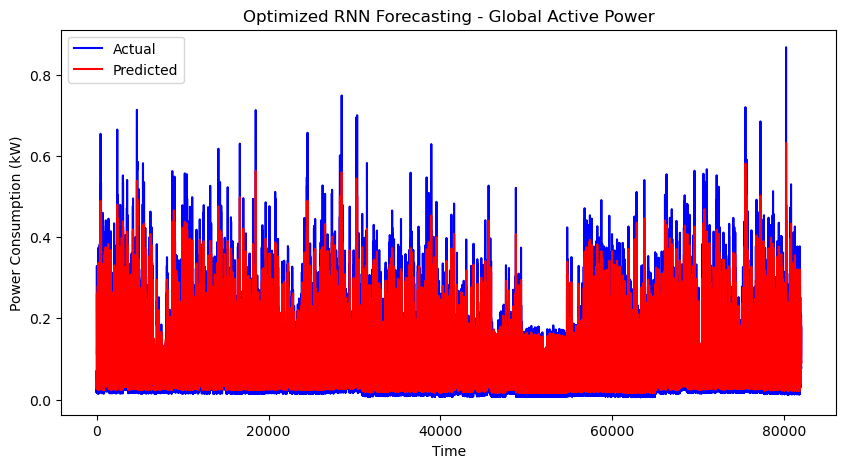

In [110]:
# Predict
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Performance metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Actual", color="blue")
plt.plot(y_pred_inv, label="Predicted", color="red")
plt.title("Optimized RNN Forecasting - Global Active Power")
plt.xlabel("Time")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.show()

### Modified LSTM

In [115]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [117]:
# Load dataset
df = pd.read_csv(r"C:\Users\USER\OneDrive\Desktop\Code\DL_tutorial\individual+household+electric+power+consumption\household_power_consumption.txt", 
                 sep=";", na_values=["?", "nan"])

df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df.drop(columns=["Date", "Time"], inplace=True)
df.set_index("datetime", inplace=True)

df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")
df.dropna(inplace=True)

# Reduce dataset size further (every 5th row)
df = df.iloc[::5, :]
scaler = MinMaxScaler()
df["Global_active_power"] = scaler.fit_transform(df[["Global_active_power"]])


In [119]:
# Function to create sequences for LSTM model
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)


In [121]:
TIME_STEPS = 10
data_values = df["Global_active_power"].values
X, y = create_sequences(data_values, TIME_STEPS)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [123]:
# Build and compile the LSTM model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(TIME_STEPS, 1)),
    Dropout(0.2),
    LSTM(25, activation="relu", return_sequences=False),
    Dense(10, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Optimized Callbacks
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler, early_stopping])


D:\jupyter\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - loss: 0.0035 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 2/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - loss: 0.0023 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 3/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - loss: 0.0023 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 4/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - loss: 0.0023 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 5/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 6/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - loss: 0.0023 - val_loss: 0.0017 - learning_rate: 2.5000e-04
Epoch 7/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 2.5000e-04
Epoch 8/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 1.2500e-04
Epoch 9/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - loss: 0.00

2562/2562 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
MAE: 0.2312, MSE: 0.1979, RMSE: 0.4448


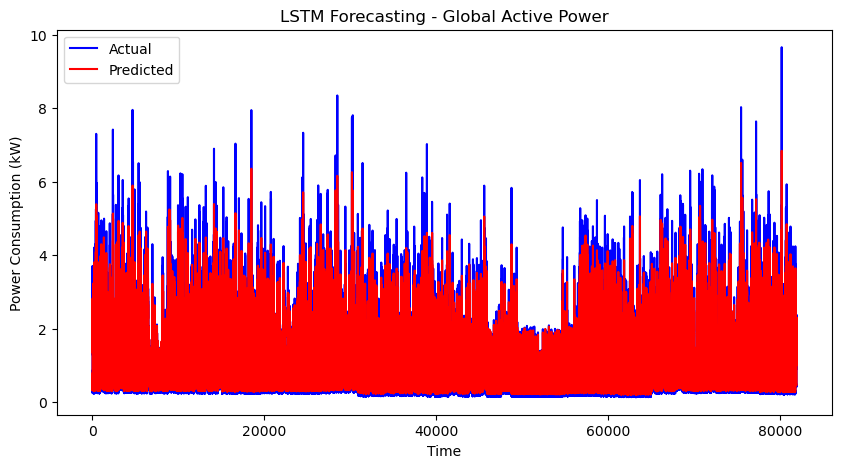

In [124]:
# Predict
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Performance metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Actual", color="blue")
plt.plot(y_pred_inv, label="Predicted", color="red")
plt.title("LSTM Forecasting - Global Active Power")
plt.xlabel("Time")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.show()

### Modified GRU

In [130]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [132]:
# Load dataset
df = pd.read_csv(r"C:\Users\USER\OneDrive\Desktop\Code\DL_tutorial\individual+household+electric+power+consumption\household_power_consumption.txt", 
                 sep=";", na_values=["?", "nan"])

df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df.drop(columns=["Date", "Time"], inplace=True)
df.set_index("datetime", inplace=True)

df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")
df.dropna(inplace=True)

# Reduce dataset size further (every 5th row)
df = df.iloc[::5, :]
scaler = MinMaxScaler()
df["Global_active_power"] = scaler.fit_transform(df[["Global_active_power"]])


In [136]:
# Function to create sequences for GRU model
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 10
data_values = df["Global_active_power"].values
X, y = create_sequences(data_values, TIME_STEPS)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for GRU input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [138]:
# Build and compile the GRU model
model = Sequential([
    GRU(50, activation="relu", return_sequences=True, input_shape=(TIME_STEPS, 1)),
    Dropout(0.2),
    GRU(25, activation="relu", return_sequences=False),
    Dense(10, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Optimized Callbacks
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler, early_stopping])


Epoch 1/20


D:\jupyter\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2562/2562 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 0.0029 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 2/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 0.0023 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 3/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 4/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 5/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 6/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 2.5000e-04
Epoch 7/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 2.5000e-04
Epoch 8/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 1.2500e-04
Epoch 9/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.0022 - val_los

2562/2562 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
MAE: 0.2265, MSE: 0.1942, RMSE: 0.4407


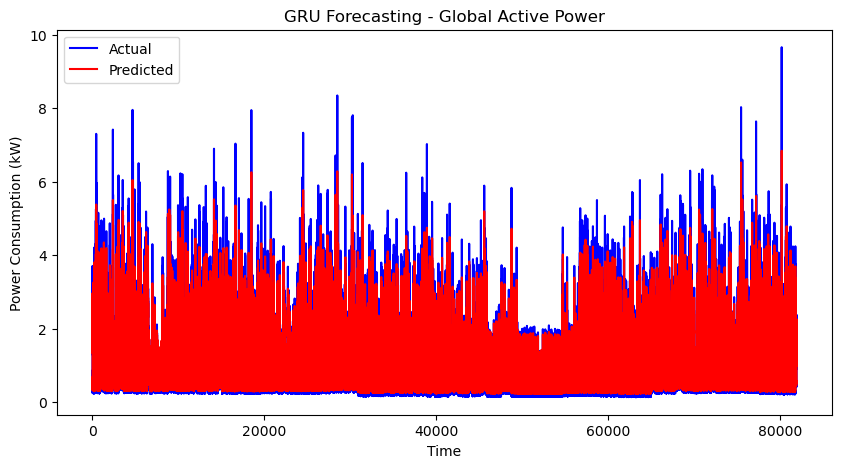

In [139]:
# Predict
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Performance metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Actual", color="blue")
plt.plot(y_pred_inv, label="Predicted", color="red")
plt.title("GRU Forecasting - Global Active Power")
plt.xlabel("Time")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.show()
